In [11]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as onp
import itertools
import datetime
import tqdm
import sys
import os

import jax.numpy as np

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")


COLOR_LIST1 = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

In [13]:
path_to_data = os.path.join(data_db_dir, "long_files_8_25_2021")

date_min            = pd.to_datetime("2020-02-01")
date_max            = pd.to_datetime("2021-02-28")
dates_simulation    = pd.date_range(start=date_min, end=date_max)
patient_df0         = pd.read_csv(os.path.join(path_to_data, "patient_data_Feb_26_2023.csv"), parse_dates=['date'])

duplicated_tests    = (patient_df0[['mrn','date','procedure_description','organism_name']].duplicated() & patient_df0['test']==1)
patient_df0         = patient_df0[~duplicated_tests]

duplicated_pos_tests = (patient_df0[['mrn','visit_id','organism_name']].duplicated() & ~patient_df0['organism_name'].isnull())
patient_df0.loc[duplicated_pos_tests,'test'] = 0
patient_df0.loc[duplicated_pos_tests,'organism_name'] = np.nan
patient_df0["ward_total"] = patient_df0.apply(lambda x: x.ward+"-"+x.building+"-"+x.ward, axis=1)


In [38]:
patient_df = patient_df0.copy()
patient_df = patient_df.drop(columns=["place", "building", "ward"]).rename(columns={"ward_total": "ward"})

wards              = patient_df.ward.unique()
counts_ward_df     = pd.DataFrame(columns=["date", "ward",
                                                "num_admitted", "num_discharged", "num_hospitalized", "num_tested", "num_outpatients"])
transfered_ward_df = pd.DataFrame(columns=["date", "ward_from", "ward_to","num_transfered"])


date  = dates_simulation[0]
today = pd.to_datetime(date)

today_df = patient_df[patient_df["date"]==today].drop_duplicates(['mrn', 'ward', 'test'])

for ward in wards:
    admitted_num     = today_df[today_df.ward==ward].mrn.unique().shape[0]
    discharged_num   = 0
    hospitalized     = today_df[today_df.ward==ward].drop_duplicates(['mrn', 'ward'])
    hospitalized_num = hospitalized.shape[0]
    tested_num       = hospitalized[hospitalized.test==1].shape[0]
    outpatients_num  = hospitalized[hospitalized.type_facility=='Outpatient'].shape[0]
    counts_ward_df   = pd.concat([counts_ward_df,
                                    pd.DataFrame([[date, ward, admitted_num, discharged_num, hospitalized_num, tested_num, outpatients_num]],
                                    columns=["date", "ward", "num_admitted", "num_discharged", "num_hospitalized", "num_tested", "num_outpatients"])])

for date in tqdm.tqdm(dates_simulation[1:]):
    #print(date)
    today     = pd.to_datetime(date)
    yesterday = pd.to_datetime(date) + datetime.timedelta(days=-1)

    today_df       = patient_df[patient_df["date"]==today].drop_duplicates(['mrn', 'ward', 'test'])
    yesterday_df   = patient_df[patient_df["date"]==yesterday].drop_duplicates(['mrn', 'ward', 'test'])

    mrns_today     = today_df.mrn.unique()     # people that were in the hospital today
    mrns_yesterday = yesterday_df.mrn.unique() # people that were in the hospital yesterday

    mrns_today_and_yesterday = list(set(mrns_today) & set(mrns_yesterday)) # people that were in both days (i.e. they stayed in the hospital)

    discharged_df = yesterday_df[~yesterday_df.mrn.isin(mrns_today)].drop_duplicates(['mrn', 'ward'])
    admitted_df   = today_df[~today_df.mrn.isin(mrns_yesterday)].drop_duplicates(['mrn', 'ward'])

    transfered_today_df     = today_df[today_df.mrn.isin(mrns_today_and_yesterday)]
    transfered_yesterday_df = yesterday_df[yesterday_df.mrn.isin(mrns_today_and_yesterday)]
    transfered_df           = pd.merge(transfered_yesterday_df[['mrn', 'ward']], transfered_today_df[['mrn','ward']],on='mrn')
    transfered_df           = transfered_df.drop_duplicates(['mrn', 'ward_x', 'ward_y'])
    transfered_df           = transfered_df[transfered_df.ward_x!=transfered_df.ward_y]
    transfered_df           = transfered_df.groupby(['ward_x','ward_y']).count()
    transfered_df           = transfered_df.reset_index()
    transfered_df           = transfered_df.rename(columns={'ward_x': 'ward_from',
                                                            'ward_y': 'ward_to',
                                                            'mrn':    'num_transfered'})
    transfered_df['date']   = date
    transfered_ward_df      = pd.concat([transfered_ward_df, transfered_df], ignore_index=True)

    for ward in wards:
        admitted_num     = admitted_df[admitted_df.ward==ward].shape[0]
        discharged_num   = discharged_df[discharged_df.ward==ward].shape[0]
        hospitalized     = today_df[today_df.ward==ward].drop_duplicates(['mrn', 'ward'])
        hospitalized_num = hospitalized.shape[0]
        tested_num       = hospitalized[hospitalized.test==1].shape[0]
        outpatients_num  = hospitalized[hospitalized.type_facility=='Outpatient'].shape[0]
        counts_ward_df   = pd.concat([counts_ward_df,
                                        pd.DataFrame([[date, ward, admitted_num, discharged_num, hospitalized_num, tested_num, outpatients_num]],
                                        columns=["date", "ward", "num_admitted", "num_discharged", "num_hospitalized", "num_tested", "num_outpatients"])])


 54%|█████▍    | 214/393 [03:34<03:50,  1.29s/it]

In [15]:
counts_ward_df.to_csv(     os.path.join(data_db_dir, "long_files_8_25_2021", "counts_ward.csv" ),   index=False)
transfered_ward_df.to_csv( os.path.join(data_db_dir, "long_files_8_25_2021", "transfers_ward.csv"), index=False)


# compare to previous analyses using building data

In [21]:
counts_ward_df

,date,ward,num_admitted,num_discharged,num_hospitalized,num_tested,num_outpatients,building
0,2020-02-03,Pby Adult Emergency-Presbyterian Hospital-Pby ...,72,61,94,0,0,Presbyterian Hospital
1,2020-02-03,Aln Emergency-Allen Hospital-Aln Emergency,40,27,67,2,0,Allen Hospital
2,2020-02-03,Hip Laboratory Grdn-Herbert Irving Pavilion-Hi...,21,0,21,0,21,Herbert Irving Pavilion
3,2020-02-03,Mil 2 Col Proc Card Med-Milstein Hospital-Mil ...,4,0,4,0,2,Milstein Hospital
4,2020-02-03,Hrt Myrna Daniels Infusion-Milstein Family Hea...,0,0,0,0,0,Milstein Family Heart Ctr
...,...,...,...,...,...,...,...,...
86627,2021-02-28,Mil 6 Hudson North-Milstein Family Heart Ctr-M...,0,0,0,0,0,Milstein Family Heart Ctr
86628,2021-02-28,Mil 6 Garden North-Mschony-Mil 6 Garden North,0,0,0,0,0,Mschony
86629,2021-02-28,Mil 6 Garden North-Harkness Pavilion-Mil 6 Gar...,0,0,1,0,0,Harkness Pavilion
86630,2021-02-28,Aln 3 River East Surge-Allen Hospital-Aln 3 Ri...,0,0,0,0,0,Allen Hospital


In [23]:
counts_ward_df["building"] = counts_ward_df.apply(lambda x: x.ward.split("-")[1], axis=1)
counts_ward_df = counts_ward_df.reset_index(drop=True)

buildings_df   = counts_ward_df.copy(); buildings_df = buildings_df.groupby(['date', 'building']).sum().reset_index()

date_start    = pd.to_datetime('2020-02-03')
date_end      = pd.to_datetime('2021-02-28')
dates         = pd.date_range(date_start, date_end)
Tdat          =  len(dates)

buildings_df = buildings_df[buildings_df.date.isin(dates)]

A     = pd.pivot(buildings_df, index='building', columns='date', values='num_admitted')
D     = pd.pivot(buildings_df, index='building', columns='date', values='num_discharged')
H     = pd.pivot(buildings_df, index='building', columns='date', values='num_hospitalized')
tests = pd.pivot(buildings_df, index='building', columns='date', values='num_tested')

pop            = H.mean(axis=1)
num_pop        = len(pop)
building_names = pop.index

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_52936/1131997060.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(pop.index,fontsize=16)


Text(0.5, 80.7222222222222, 'mean length of stay (days)')

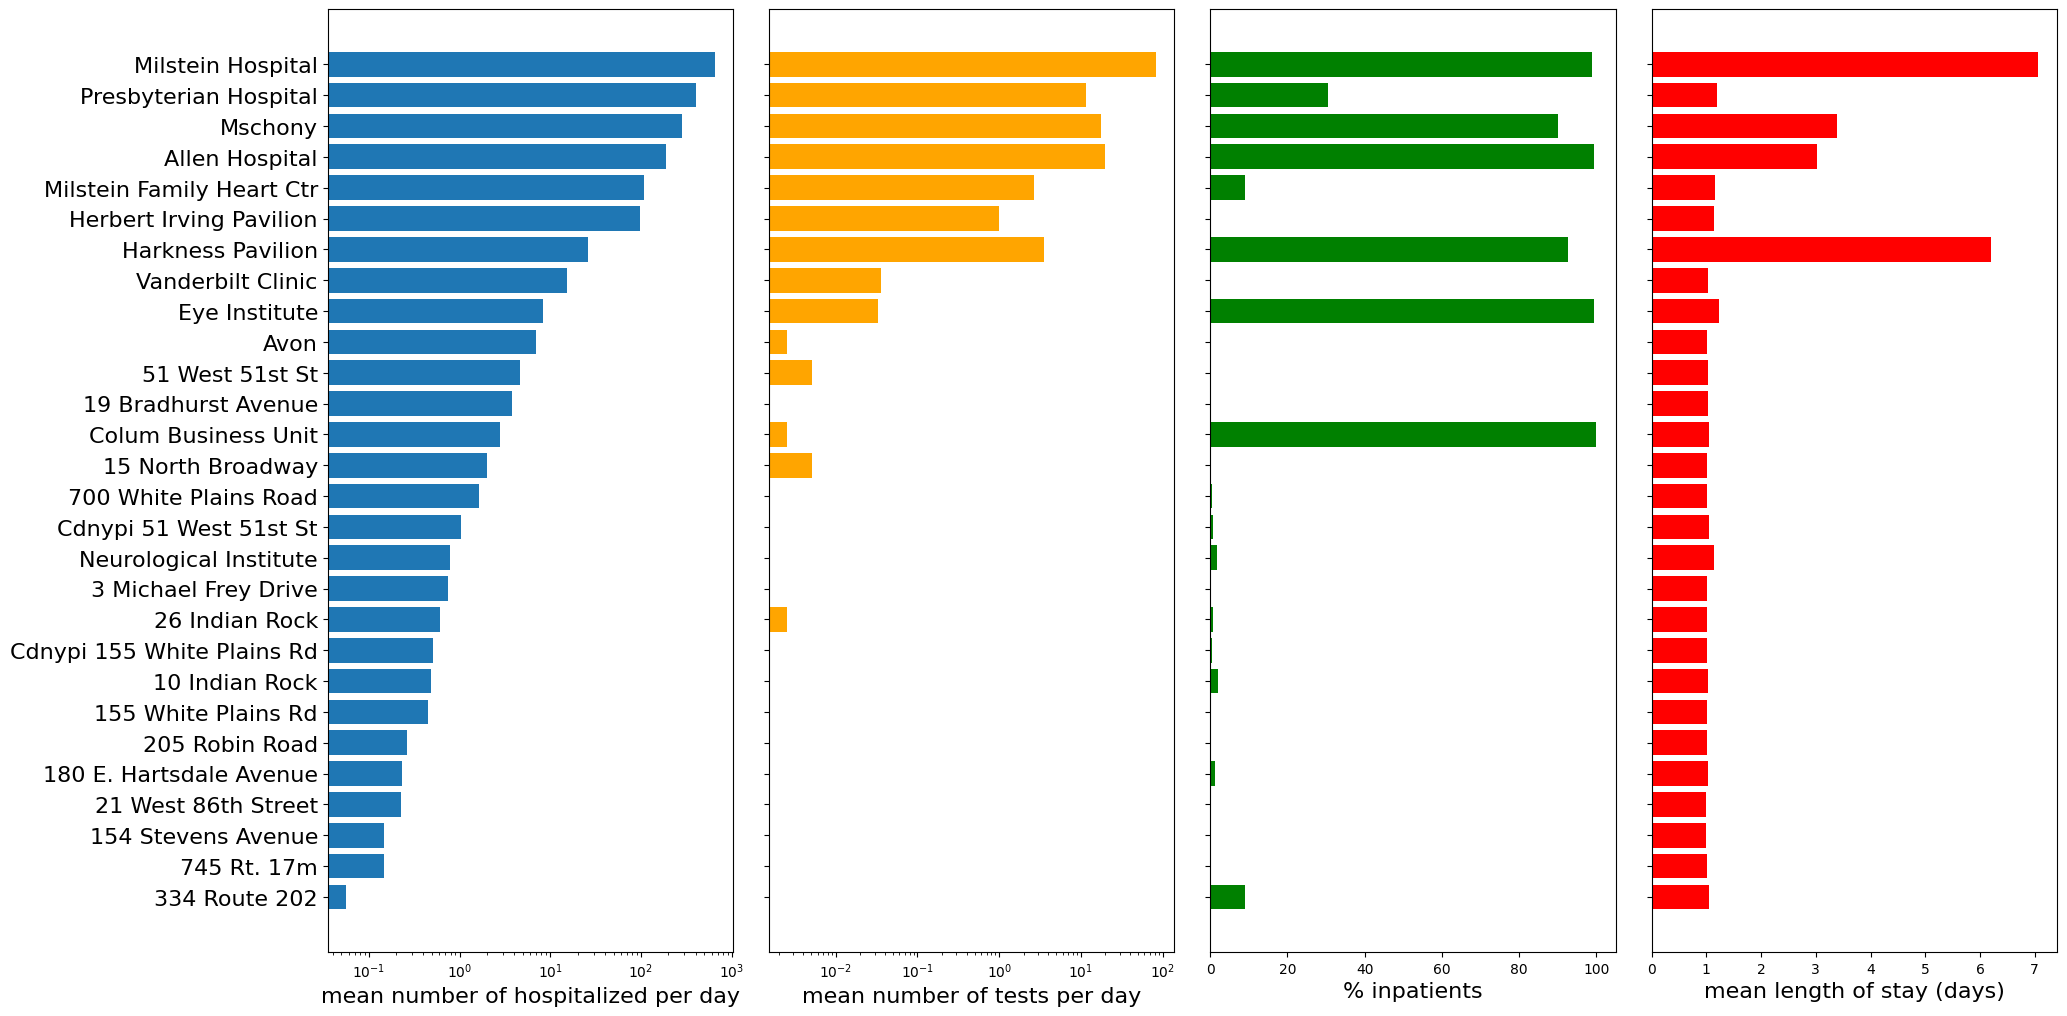

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(18,10), nrows=1, ncols=4, sharey=True)
fig.tight_layout(pad=1)

pop = pop.sort_values(ascending=True)
axes[0].barh(y=pop.index, width=pop)
axes[0].set_xlabel('mean number of hospitalized per day',fontsize=16)
axes[0].set_yticklabels(pop.index,fontsize=16)
axes[0].set_xscale('log')

tests_mean = tests.mean(axis=1)
axes[1].barh(y=pop.index, width=tests_mean[pop.index],color='orange')
axes[1].set_xlabel('mean number of tests per day',fontsize=16)
axes[1].set_xscale('log')


O = pd.pivot(buildings_df, index='building',columns='date',values='num_outpatients')
inp = 100*(1-O.sum(axis=1)/H.sum(axis=1))
axes[2].barh(y=pop.index, width=inp[pop.index],color='green')
axes[2].set_xlabel('% inpatients',fontsize=16)

los = H.sum(axis=1)/A.sum(axis=1)
axes[3].barh(y=pop.index, width=los[pop.index],color='red')
axes[3].set_xlabel('mean length of stay (days)',fontsize=16)


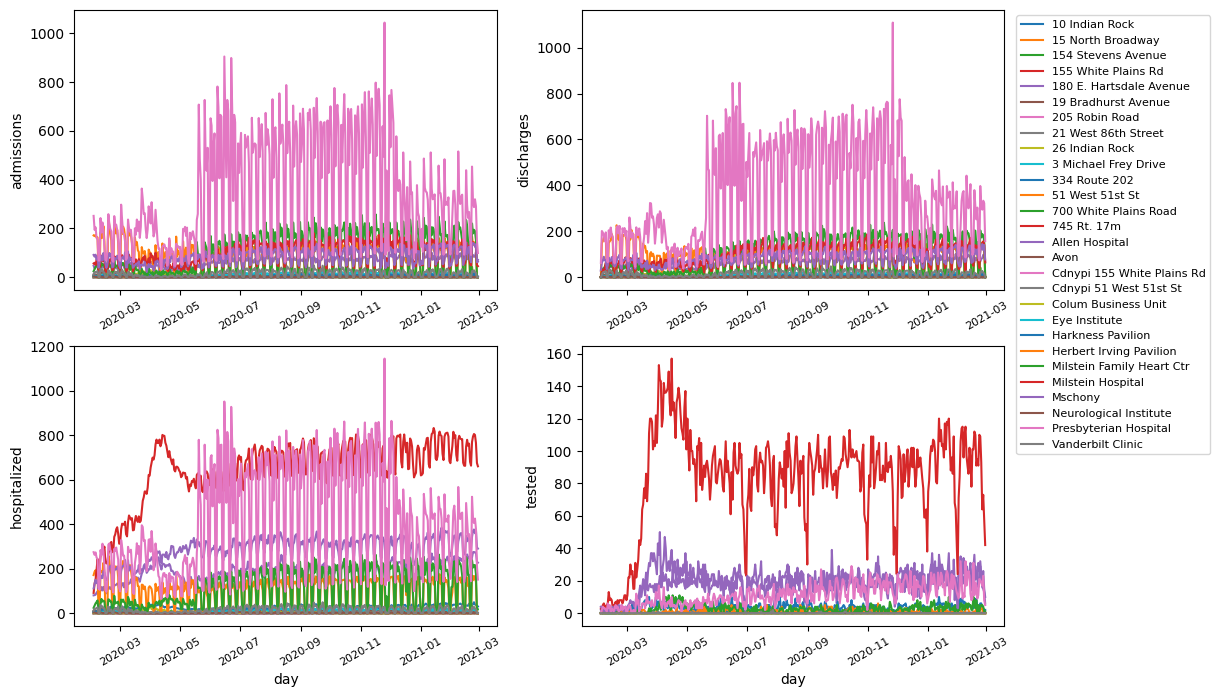

In [33]:
fig, axes = plt.subplots(figsize=(12,8), nrows=2, ncols=2)
axes[0,0].plot(A.T)
#axes[0,0].set_xlabel('day')
axes[0,0].set_ylabel('admissions')
axes[0,0].tick_params(axis='x', labelrotation = 30, labelsize=8)

axes[0,1].plot(D.T)
#axes[0,1].set_xlabel('day')
axes[0,1].set_ylabel('discharges')
axes[0,1].tick_params(axis='x', labelrotation = 30, labelsize=8)
axes[1, 0].plot(H.T)

axes[1, 0].set_xlabel('day')
axes[1, 0].set_ylabel('hospitalized')
axes[1, 0].tick_params(axis='x', labelrotation = 30, labelsize=8)

axes[1,1].plot(tests.T)
axes[1,1].set_xlabel('day')
axes[1,1].set_ylabel('tested')
axes[1,1].tick_params(axis='x', labelrotation = 30, labelsize=8)

axes[0, 1].legend(building_names, prop={'size': 8},loc='upper right', bbox_to_anchor=(1.5, 1.0))



# ward level with selected buildings

In [ ]:
selected_building = ['Allen Hospital', 'Harkness Pavilion', 'Milstein Hospital', 'Mschony', 'Presbyterian Hospital']
